# tutorial

A. link to helpful python docs

Recapitation, Simplification, and Mutation: https://pyslim.readthedocs.io/en/latest/tutorial.html#recapitation-simplification-and-mutation

Saving Individuals in .trees file: https://pyslim.readthedocs.io/en/latest/tutorial.html#obtaining-and-saving-individuals

Some Basic Plotting:
https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/
(Esther's note: I'm not sure if this site is reliable but it helped me, so feel free to remove!)

B. Which packages you need and what they do and link to docs

What is pyslim + how to install: https://pypi.org/project/pyslim/

What is tskit: https://tskit.dev/tskit/docs/stable/introduction.html
    + Install tskit: https://tskit.dev/tskit/docs/stable/installation.html

What is NumPy, install, import: https://numpy.org/doc/stable/user/absolute_beginners.html

What is Msprime: https://tskit.dev/msprime/docs/stable/quickstart.html
    + Install Msprime: https://tskit.dev/msprime/docs/stable/installation.html#sec-installation

Install IPython: https://ipython.org/install.html
	(SVG from IPython.display allows us to display trees in SVG format)
    
What is Matplotlib: https://matplotlib.org/stable/index.html
    + Install Matplotlib: https://matplotlib.org/stable/users/installing.html
    (We can use things like matplotlib.pyplot as plt for plotting, matplotlib.cm as cm 
    for color maps, and various widgets)

In [1]:
#If we want to be able to rotate 3D plots, we can set up the matplotlib widget tool.
%matplotlib widget
#We can import these packages in our notebooks like this:
import pyslim, tskit
import numpy as np
import msprime
from IPython.display import SVG #for displaying trees in svg format
import matplotlib
import matplotlib.pyplot as plt #plotting
import matplotlib.cm as cm #color maps
#%matplotlib inline

In [2]:
import os #module to run commands on the code line from within python
SLiM = 'slim' #command to run SLiM from your command line

# BASICS

## 0. run a slim sim (Matt)

We first write out our SLiM script as text

In [3]:
SLiM_script = """
initialize() {

   setSeed(1);                                    // set seed for repeatability
   initializeSLiMModelType("nonWF");              // non-Wright-Fisher to allow for local density-dependence and prevent clumping
   initializeSLiMOptions(dimensionality="xy");    // 2 dimensions
   initializeTreeSeq(retainCoalescentOnly=F);     // keep all ancestors that remain in tree sequence
   initializeMutationRate(0.0);                   // we will ignore mutations for now and just deal with the trees
   initializeMutationType("m1", 0.5, "f", 0.0);
   initializeGenomicElementType("g1", m1, 1.0);
   initializeGenomicElement(g1, 0, 999999);       // 1Mb chromosome
   initializeRecombinationRate(1e-8);             // some recombination so we get multiple trees

   // parameter values
   defineConstant("LAMBDA", 4.0); // birth rate
   defineConstant("K", 2.0);      // carrying capacity per unit area
   defineConstant("W", 10);       // width and height of the area
   defineConstant("SIGMA", 0.1);  // interaction and dispersal distance
   
   // spatial interaction for local competition
   initializeInteractionType("i1", "xy", reciprocal=T, maxDistance = 10 * SIGMA);  // interaction for both mate choice and density dependence
   i1.setInteractionFunction("n", 1.0/(2*PI*SIGMA^2), SIGMA);                      // normally distributed around the focal individual with variance SIGMA^2 along both axes
}

reproduction() {
   neighbor_density = i1.totalOfNeighborStrengths(individual);     // strength of competition felt from neighbours
   num_offspring = rpois(1, LAMBDA / (1 + neighbor_density / K));  // number of offspring is Poisson distributed with a mean depending on LAMBDA, neighbor_density, and K
   mate = i1.drawByStrength(individual, 1);                        // single mate drawn randomly weighted by interaction strengths
   if (size(mate) > 0) {                                           // if there is a mate (might not be if no neighbors)
       for (k in seqLen(num_offspring)) {                          // for each offspring
           offspring = p1.addCrossed(individual, mate);            // create by recombination
           pos = individual.spatialPosition + rnorm(2, 0, SIGMA);  // position of offspring is normally distributed around "mother" with variance SIGMA in both axes
           offspring.setSpatialPosition(p1.pointReflected(pos));   // reflecting boundaries
       }
   }
}

1 early() {
   
   
   sim.addSubpop("p1", 2);  //start with just two ancestors (helps make everyone coalesce in a short time)                     

   p1.setSpatialBounds(c(0.0, 0.0, W, W)); // set spatial bounds (square with width W)
   
   // start ancestors in 1x1 square in the center of range
   p1.individuals.x = runif(p1.individualCount) + (W-1)/2; 
   p1.individuals.y = runif(p1.individualCount) + (W-1)/2;
}

early() { 
    p1.fitnessScaling = 1;                   // density dependence occurs in fecundity
    inds = sim.subpopulations.individuals;
    inds[inds.age > 0].fitnessScaling = 0.0; // enforce discrete generations
}

late() {
   i1.evaluate(); //evaluate interaction strengths for next generation
}

late() {
   sim.treeSeqRememberIndividuals(p1.individuals, permanent=F); // retain individuals remaining in the tree sequence
}

1000 late() { 
   sim.treeSeqOutput("spatial_sim.trees"); //save the tree sequence
   catn("Done.");
   sim.simulationFinished();
}

"""

now we run this from the command line (should get a "0" if it worked)

In [4]:
os.system("echo '" + SLiM_script + "' | " + SLiM) #we "echo" the text above and "pipe" it to SLiM

0

## 1. load and simplify tree sequence to a sample (Nadine)

just writing a very brief version here in the meantime, Nadine, so we can work on the sections below, but go ahead and update and annotate this as you like

In [5]:
ts = pyslim.load('spatial_sim.trees') #load tree sequence
np.random.seed(1); n = 5; sampled_nodes = np.random.choice(ts.samples(), 5, replace=False) #take sample of n nodes without replacement (set seed for repeatability)
sts = ts.simplify(sampled_nodes, keep_unary=True) #simplify but keep unary nodes & individuals
# SVG(sts.draw_svg()) #draw if you wish (but kind of ugly with all the unary nodes)
sts #print some summaries of the simplified tree sequence

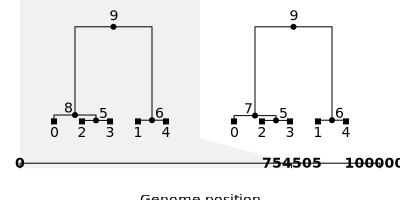

In [6]:
# draw the tree sequence without the unary nodes if you'd like! (there will likely be many fewer trees)
SVG(sts.simplify(keep_unary=False).draw_svg())

## 2. locate children and parents (Pam)

### traversing up a tree

In [23]:
tree0 = ts.at_index(0)

tree0.draw_svg()

'<svg baseProfile="full" height="200" version="1.1" width="200" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs><style type="text/css"><![CDATA[.background path {fill: #808080; fill-opacity:0}.background path:nth-child(odd) {fill-opacity:.1}.axes {font-size: 14px}.x-axis .tick .lab {font-weight: bold}.axes, .tree {font-size: 14px; text-anchor:middle}.y-axis line.grid {stroke: #FAFAFA}.y-axis > .lab text {transform: translateX(0.8em) rotate(-90deg)}.x-axis .tick g {transform: translateY(0.9em)}.x-axis > .lab text {transform: translateY(-0.8em)}.axes line, .edge {stroke:black; fill:none}.node > .sym {fill: black; stroke: none}.site > .sym {stroke: black}.mut text {fill: red; font-style: italic}.mut.extra text {fill: hotpink}.mut line {fill: none; stroke: none}.mut .sym {fill: none; stroke: red}.mut.extra .sym {stroke: hotpink}.node .mut .sym {stroke-width: 1.5px}.tree text, .tree-sequence text {dominant-base

In [17]:
tree0 = ts.at_index(0)

test = []

for edge in tree0.edges():
    p_ch_nodes.append(edge.parent)

print(test)

AttributeError: 'Tree' object has no attribute 'edges'

### all edges in the tree sequence

I gotta fix this code because it's really slowing down the notebook.

In [7]:
#p_ch_nodes = [] #we make an empty array to hold parent and child nodes

#for edge in sts.edges():
 #   p_ch_nodes.append(edge.parent) #we append the parent node for the edge
 #   p_ch_nodes.append(edge.child) #we append the child node for the edge
# now each parent node is followed by its child node



#p_ch_inds = []

#for i in p_ch_nodes:
 #   for node in sts.nodes():
 #       if i == node.id:
#            p_ch_inds.append(node.individual)
# now each parent individual is followed by its child individual

## 3. 2D plotting space trees (Esther)

## 4. 3D plotting (Alex)

In [8]:
#Now it's time to plot something! 3d plots are great for looking at changes in patterns over time.
#Let's say we want to see how the positions of individuals in the tree sequence change over time.
#It's easiest and cleanest to set this up by defining a function in Python, then running it for the tree sequence.

def positions(ts):
    #First, we set up the plot using matplotlib.
    fig = plt.figure()
    threed = fig.add_subplot(projection='3d')

    #We need to create lists in which we will hold the x- and y-coordinates of individuals & the time they were born.
    x, y, t = [], [], []
    
    #Now, we iterate over the individuals in the tree sequence and get their positions & birthdates.
    for ind in ts.individuals():
        #The location attribute of the individual class is an array of the coordinates where the individual is located.
        x_pos = ind.location[0]
        y_pos = ind.location[1]
        time = ind.time
        #Now, we append these values to the lists we created.
        x.append(x_pos)
        y.append(y_pos)
        t.append(time)
    #Time to put it on the plot! First, let's set the z-axis to include all of the generational numbers in our simulation.
    #Because tree sequences count generations backwards, we put the axis in reverse so the final gen is on the top.
    threed.set_zlim([1000,0])
    #So that we can see our data, let's set the size of the points to 2.0. The default size is 10.0.
    threed.scatter3D(x, y, t, s=2.0)

#Let's give our function a go with the simplified tree sequence now:
positions(sts)
#With the %matplotlib widget feature at the very beginning of the code, we can rotate our graph
# & see precisely how individuals are positioned in each generation.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
#Well, that 

# EXTENSIONS

## mutations/selected alleles (Alex)

## discrete space / metapopulations (Pam)

## slendr (fair game!)